### This notebook Summary

This notebook is for feature computation, converting time series data into 128x128 formatted image data.<br>
(このノートブックは時系列データを128x128の整形された画像データに変換する、特徴量計算用のノートブックです。)<br>

The data size of 128x128 is too large, so we published 32x32.<br>
(128x128はデータサイズが大きすぎるため、32x32を公開していましたが、)<br>
However, 128x128 is output as jpeg because it can be encoded as jpeg and the size is practical.<br>
(jpegで符号化すれば実用的なサイズになるため、128x128はjpegで出力しています。)<br>

For 32x32, please refer to version 21 of this notebook.<br>
(32x32はこのnotebookのversion 21を参照してください。)<br>
For 128x128, please refer to version 22 of this notebook.<br>
(128x128はこのnotebookのversion 22を参照してください。)<br>

This notebook is also part of the imaging of all samples. For the full data set, please refer to the dataset below.<br>
(またこのnotebookは全サンプルの画像化の一部となっています。全データは以下のデータセットを参照ください。)<br>
- [G2Net VQT features 32x32 and 128x128](https://www.kaggle.com/snkmr0221/g2net-vqt-features-32x32-img)

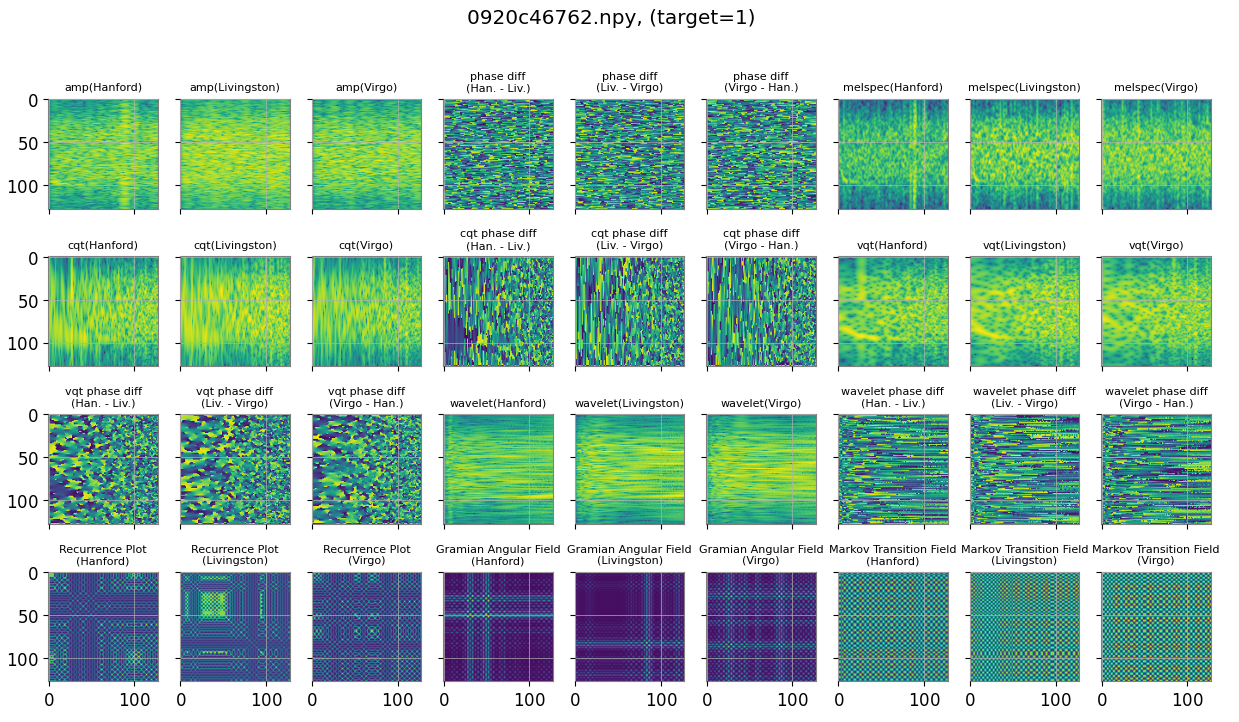<br>

From the time series data of 3 sites and 4096 samples, we calculate 36 image data. The list of image data is as follows.<br>
(3サイト、4096サンプルの時系列データから、36個の画像データを計算します。画像データのリストは以下です。)<br>
- 1-3. Amplitude spectrum for each site(各サイトの振幅スペクトル)
- 4-6. phase difference spectrum for each site(各サイト間の位相差スペクトル)
- 7-9. mel frequency spectrum for each site(各サイトのメル周波数スペクトル)
- 10-12. CQT amplitude spectrum for each site(各サイトのCQT振幅スペクトル)
- 13-15. CQT phase difference spectrum between each site(各サイト間のCQT位相差スペクトル)
- 16-18. VQT amplitude spectrum for each site(各サイトのVQT振幅スペクトル)
- 19-21. VQT phase difference spectrum between each site(各サイト間のVQT位相差スペクトル)
- 22-24. wavelet transform amplitude spectrum for each site(各サイトのwavelet変換の振幅スペクトル)
- 25-27. phase difference spectrum of wavelet transform between each site(各サイト間のwavelet変換の位相差スペクトル)
- 28-30. recurrence plots for each site(各サイトのReccurence Plot)
- 31-33. Gramian Angular Field for each site(各サイトのGramian Angular Field)
- 34-36. Markov Transition Field for each site(各サイトのMarkov Transition Field)

Visualization of these image data was performed for one part of the sample file.<br>
(1部のサンプルファイルについて、これらの画像データの可視化を実施しました。)<br>
In this image data, VQT seemed to have the most obvious features in the graph.<br>
(この画像データの中で、VQTがグラフ上最もわかりやすい特徴を持っているように見えました。)<br>

In addition, it is very time consuming to perform all the image data calculations.<br>
(またすべての画像データ計算処理を実行するのは、とても時間がかかります。)<br>
Therefore, in the end, this notebook will output only a part of the VQT data.<br>
(そのため、最終的にはこのnotebookでは、VQTデータの一部のみを出力します。)<br>
If you want to use image data from other data, you need to modify the NOTEBOOK and run it. <br>
(他のデータの画像データを使う場合は、notebookを修正して実行する必要があります。)<br>

### References

For more information about Mel frequency spectrum, please refer to the following notebook.<br>
(メル周波数スペクトルについては、以下のnotebookを参考にしています。)<br>
- https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-train

I have never heard of the 28-36 process before, but I am referring to the following notebook.<br>
(28-36の処理については、初めて知りましたが、以下のnotebookを参考にしています。)<br>
- https://www.kaggle.com/abhishek1aa/g2net-exploring-data-representations

For preprocessing, I refer to the following notebook.<br>
(前処理については以下のnotebookを参考にしています。)<br>
- https://www.kaggle.com/mistag/data-preprocessing-with-gwpy

### imports

In [ ]:
# standard lib
import pathlib

# third party
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy
import scipy.signal as signal
import pywt
import librosa
from matplotlib import pyplot as plt
from PIL import Image
!pip install pyts
from pyts.image import RecurrencePlot, GramianAngularField, MarkovTransitionField
!pip install gwpy
from gwpy.timeseries import TimeSeries

### functions

In [ ]:
def preprocess(sig: np.ndarray):
    window = signal.tukey(sig_org.shape[-1])
    sig_pp = sig*window
    return sig_pp
#     for i in range(3):
#         ts = TimeSeries(sig[i,:], sample_rate=2048)
#         window = signal.tukey(sig.shape[1])
#         ts = ts * window
#         ts = ts.whiten()

#         if i==0:
#             sig_pp = ts.reshape(1,sig.shape[1])
#         else:
#             sig_pp = np.concatenate([sig_pp, ts.reshape(1,sig.shape[1])], axis=0)
#     return sig_pp

def jpeg_codec(spec):
    out = spec.copy()
    norm = ((spec-np.min(spec))/(np.max(spec)-np.min(spec))*255).astype(np.uint8)
    for i in range(3):
        jpeg_enc = tf.image.encode_jpeg(norm[i,:,:].reshape(norm.shape[1],norm.shape[2],1))
        jpeg_dec = tf.image.decode_jpeg(jpeg_enc)
        out[i,:,:] = jpeg_dec.numpy().reshape(norm.shape[1], norm.shape[2])
    return out.astype(np.uint8)

def jpeg_enc(spec):
    norm = ((spec-np.min(spec))/(np.max(spec)-np.min(spec))*255).astype(np.uint8)
    
    jpeg_enc0 = tf.image.encode_jpeg(norm[0,:,:].reshape(norm.shape[1],norm.shape[2],1))
    jpeg_enc1 = tf.image.encode_jpeg(norm[1,:,:].reshape(norm.shape[1],norm.shape[2],1))
    jpeg_enc2 = tf.image.encode_jpeg(norm[2,:,:].reshape(norm.shape[1],norm.shape[2],1))
    return jpeg_enc0, jpeg_enc1, jpeg_enc2

def png_enc(spec):
    norm = ((spec-np.min(spec))/(np.max(spec)-np.min(spec))*255).astype(np.uint8)
    
    enc0 = tf.image.encode_png(norm[0,:,:].reshape(norm.shape[1],norm.shape[2],1))
    enc1 = tf.image.encode_png(norm[1,:,:].reshape(norm.shape[1],norm.shape[2],1))
    enc2 = tf.image.encode_png(norm[2,:,:].reshape(norm.shape[1],norm.shape[2],1))
    return enc0, enc1, enc2

def resize(X):
    return X
#     for i in range(3):
#         img = Image.fromarray(X[i])
#         img = img.resize((img.width // 4, img.height // 4), Image.LANCZOS)
#         img = np.asarray(img)
#         if i==0:
#             Y = img.reshape(1,img.shape[0],img.shape[1])
#         else:
#             Y = np.concatenate([Y,img.reshape(1,img.shape[0],img.shape[1])], axis=0)
#     return Y

def feature_spectrogram(sig: np.ndarray):
    f, t, spec = signal.spectrogram(sig, fs=2048, nfft=256, nperseg=35, mode='complex')
    
    spec_cross = spec[0]/spec[1]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = P.reshape(1,P.shape[0],P.shape[1])
    
    spec_cross = spec[1]/spec[2]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = np.concatenate([phase, P.reshape(1,P.shape[0],P.shape[1])], axis=0)
    
    spec_cross = spec[2]/spec[0]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = np.concatenate([phase, P.reshape(1,P.shape[0],P.shape[1])], axis=0)
    
    spec = np.log10(np.abs(spec[:,:-1,1:-3]))
    phase = phase[:,:-1,1:-3]
    spec = resize(spec)
    phase = resize(phase)

    return spec, phase

def feature_mel_spectrogram(sig: np.ndarray):
    for i in range(3):
        F = librosa.feature.melspectrogram(sig[i] / max(sig[i]), sr=2048, n_mels=128, win_length=256, hop_length=32)
        F = librosa.power_to_db(F)
        if i==0:
            spec = F.reshape(1,F.shape[0],F.shape[1])
        else:
            spec = np.concatenate([spec, F.reshape(1,F.shape[0],F.shape[1])], axis=0)
            
    spec = spec[:,:,1:]
    spec = resize(spec)
    return spec

def feature_cqt(sig: np.ndarray):
    for i in range(3):
        F = librosa.cqt(sig[i] / max(sig[i]), sr=2048, n_bins=128, hop_length=32, bins_per_octave=32)
        # F = librosa.power_to_db(F)
        if i==0:
            spec = F.reshape(1,F.shape[0],F.shape[1])
        else:
            spec = np.concatenate([spec, F.reshape(1,F.shape[0],F.shape[1])], axis=0)
            
    spec_cross = spec[0]/spec[1]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = P.reshape(1,P.shape[0],P.shape[1])
    
    spec_cross = spec[1]/spec[2]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = np.concatenate([phase, P.reshape(1,P.shape[0],P.shape[1])], axis=0)
    
    spec_cross = spec[2]/spec[0]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = np.concatenate([phase, P.reshape(1,P.shape[0],P.shape[1])], axis=0)
    
    spec = librosa.power_to_db(np.abs(spec[:,:,1:]))
    phase = phase[:,:,1:]
    spec = resize(spec)
    phase = resize(phase)
    
    return spec, phase

def feature_vqt(sig: np.ndarray):
    for i in range(3):
        F = librosa.vqt(sig[i] / max(sig[i]), sr=2048, n_bins=128, hop_length=32, bins_per_octave=32)
        if i==0:
            spec = F.reshape(1,F.shape[0],F.shape[1])
        else:
            spec = np.concatenate([spec, F.reshape(1,F.shape[0],F.shape[1])], axis=0)
            
    spec_cross = spec[0]/spec[1]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = P.reshape(1,P.shape[0],P.shape[1])
    
    spec_cross = spec[1]/spec[2]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = np.concatenate([phase, P.reshape(1,P.shape[0],P.shape[1])], axis=0)
    
    spec_cross = spec[2]/spec[0]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = np.concatenate([phase, P.reshape(1,P.shape[0],P.shape[1])], axis=0)
    
    spec = librosa.power_to_db(np.abs(spec[:,:,1:]))
    phase = phase[:,:,1:]
    spec = resize(spec)
    phase = resize(phase)
    
    return spec, phase

def feature_wavelet(sig: np.ndarray):
    cwt, freqs = pywt.cwt(sig, scales=np.arange(1, 31, 0.23), wavelet='cmor1.5-1.0', sampling_period=1/2048, method='fft')
    cwt = cwt.transpose(1,0,2)

    spec_cross = cwt[0]/cwt[1]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = P.reshape(1,P.shape[0],P.shape[1])
    
    spec_cross = cwt[1]/cwt[2]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = np.concatenate([phase, P.reshape(1,P.shape[0],P.shape[1])], axis=0)
    
    spec_cross = cwt[2]/cwt[0]
    P = np.arctan2(spec_cross.imag, spec_cross.real)
    phase = np.concatenate([phase, P.reshape(1,P.shape[0],P.shape[1])], axis=0)

    spec = np.log10(np.abs(cwt[:,:-3,::32]))
    phase = phase[:,:-3,::32]
    spec = resize(spec)
    phase = resize(phase)
    
    return spec, phase

def feature_rp(sig: np.ndarray):
    for i in range(3):
        rp = RecurrencePlot(threshold='point', percentage=20)
        _, X = rp.fit_transform((np.arange(len(sig[i])),sig[i]))
        
        img = Image.fromarray(X)
        img = img.resize((img.width // 32, img.height // 32), Image.LANCZOS)
        # img = img.resize((img.width // 128, img.height // 128), Image.LANCZOS)
        X = np.asarray(img)
        
        if i==0:
            spec = X.reshape(1,X.shape[0],X.shape[1])
        else:
            spec = np.concatenate([spec, X.reshape(1,X.shape[0],X.shape[1])], axis=0)
    return spec[:,::1, ::1]

def feature_gaf(sig: np.ndarray):
    for i in range(3):
        gaf = GramianAngularField(image_size=4096, method='summation')
        _, X = gaf.fit_transform((np.arange(len(sig[i])),sig[i]))
        
        img = Image.fromarray(X)
        img = img.resize((img.width // 32, img.height // 32), Image.LANCZOS)
        # img = img.resize((img.width // 128, img.height // 128), Image.LANCZOS)
        X = np.asarray(img)
        
        if i==0:
            spec = X.reshape(1,X.shape[0],X.shape[1])
        else:
            spec = np.concatenate([spec, X.reshape(1,X.shape[0],X.shape[1])], axis=0)
    return spec

def feature_mtf(sig: np.ndarray):
    for i in range(3):
        mtf = MarkovTransitionField(image_size = 4096, n_bins=2)
        _, X = mtf.fit_transform((np.arange(len(sig[i])),sig[i]))
        
        img = Image.fromarray(X)
        img = img.resize((img.width // 32, img.height // 32), Image.LANCZOS)
        # img = img.resize((img.width // 128, img.height // 128), Image.LANCZOS)
        X = np.asarray(img)
        
        if i==0:
            spec = X.reshape(1,X.shape[0],X.shape[1])
        else:
            spec = np.concatenate([spec, X.reshape(1,X.shape[0],X.shape[1])], axis=0)
    return spec

### get file list and target indexes

In [ ]:
%%time
root_path = pathlib.Path('/kaggle/input/g2net-gravitational-wave-detection')
train_files = sorted(root_path.joinpath('train').glob('**/*.*'))
test_files = sorted(root_path.joinpath('test').glob('**/*.*'))
print(f"train_num: {len(train_files)}, test_num: {len(test_files)}")
sub_file = pd.read_csv(root_path.joinpath('sample_submission.csv'))
# print(sub_file.loc[:10,:])
train_labels = pd.read_csv(root_path.joinpath('training_labels.csv'))
print(f"label stats: \n{train_labels['target'].value_counts()}")

train_target0_index = train_labels[train_labels["target"]==0].index
train_target1_index = train_labels[train_labels["target"]==1].index

### visualize

In [ ]:
%%time
sig_file = pathlib.Path(train_files[train_target1_index[10000]])
sig_org = np.load(sig_file)

sig = preprocess(sig_org)
spec, phase = feature_spectrogram(sig)
melspec = feature_mel_spectrogram(sig)
cqt, cqt_ph = feature_cqt(sig)
vqt, vqt_ph = feature_vqt(sig)
cwt, cwt_ph = feature_wavelet(sig)
rp = feature_rp(sig_org)
gaf = feature_gaf(sig_org)
mtf = feature_mtf(sig_org)

fig, ax = plt.subplots(4, 9, sharex=True, sharey=True, figsize=(15, 8), dpi=100)

ax[0,0].imshow(spec   [0].transpose()); ax[0,0].set_title("amp(Hanford)", fontsize=8)
ax[0,1].imshow(spec   [1].transpose()); ax[0,1].set_title("amp(Livingston)", fontsize=8)
ax[0,2].imshow(spec   [2].transpose()); ax[0,2].set_title("amp(Virgo)", fontsize=8)
ax[0,3].imshow(phase  [0].transpose()); ax[0,3].set_title("phase diff\n(Han. - Liv.)", fontsize=8)
ax[0,4].imshow(phase  [1].transpose()); ax[0,4].set_title("phase diff\n(Liv. - Virgo)", fontsize=8)
ax[0,5].imshow(phase  [2].transpose()); ax[0,5].set_title("phase diff\n(Virgo - Han.)", fontsize=8)
ax[0,6].imshow(melspec[0].transpose()); ax[0,6].set_title("melspec(Hanford)", fontsize=8)
ax[0,7].imshow(melspec[1].transpose()); ax[0,7].set_title("melspec(Livingston)", fontsize=8)
ax[0,8].imshow(melspec[2].transpose()); ax[0,8].set_title("melspec(Virgo)", fontsize=8)
ax[1,0].imshow(cqt    [0].transpose()); ax[1,0].set_title("cqt(Hanford)", fontsize=8)
ax[1,1].imshow(cqt    [1].transpose()); ax[1,1].set_title("cqt(Livingston)", fontsize=8)
ax[1,2].imshow(cqt    [2].transpose()); ax[1,2].set_title("cqt(Virgo)", fontsize=8)
ax[1,3].imshow(cqt_ph [0].transpose()); ax[1,3].set_title("cqt phase diff\n(Han. - Liv.)", fontsize=8)
ax[1,4].imshow(cqt_ph [1].transpose()); ax[1,4].set_title("cqt phase diff\n(Liv. - Virgo)", fontsize=8)
ax[1,5].imshow(cqt_ph [2].transpose()); ax[1,5].set_title("cqt phase diff\n(Virgo - Han.)", fontsize=8)
ax[1,6].imshow(vqt    [0].transpose()); ax[1,6].set_title("vqt(Hanford)", fontsize=8)
ax[1,7].imshow(vqt    [1].transpose()); ax[1,7].set_title("vqt(Livingston)", fontsize=8)
ax[1,8].imshow(vqt    [2].transpose()); ax[1,8].set_title("vqt(Virgo)", fontsize=8)
ax[2,0].imshow(vqt_ph [0].transpose()); ax[2,0].set_title("vqt phase diff\n(Han. - Liv.)", fontsize=8)
ax[2,1].imshow(vqt_ph [1].transpose()); ax[2,1].set_title("vqt phase diff\n(Liv. - Virgo)", fontsize=8)
ax[2,2].imshow(vqt_ph [2].transpose()); ax[2,2].set_title("vqt phase diff\n(Virgo - Han.)", fontsize=8)
ax[2,3].imshow(cwt    [0].transpose()); ax[2,3].set_title("wavelet(Hanford)", fontsize=8)
ax[2,4].imshow(cwt    [1].transpose()); ax[2,4].set_title("wavelet(Livingston)", fontsize=8)
ax[2,5].imshow(cwt    [2].transpose()); ax[2,5].set_title("wavelet(Virgo)", fontsize=8)
ax[2,6].imshow(cwt_ph [0].transpose()); ax[2,6].set_title("wavelet phase diff\n(Han. - Liv.)", fontsize=8)
ax[2,7].imshow(cwt_ph [1].transpose()); ax[2,7].set_title("wavelet phase diff\n(Liv. - Virgo)", fontsize=8)
ax[2,8].imshow(cwt_ph [2].transpose()); ax[2,8].set_title("wavelet phase diff\n(Virgo - Han.)", fontsize=8)
ax[3,0].imshow(rp     [0].transpose()); ax[3,0].set_title("Recurrence Plot\n(Hanford)", fontsize=8)
ax[3,1].imshow(rp     [1].transpose()); ax[3,1].set_title("Recurrence Plot\n(Livingston)", fontsize=8)
ax[3,2].imshow(rp     [2].transpose()); ax[3,2].set_title("Recurrence Plot\n(Virgo)", fontsize=8)
ax[3,3].imshow(gaf    [0].transpose()); ax[3,3].set_title("Gramian Angular Field\n(Hanford)", fontsize=8)
ax[3,4].imshow(gaf    [1].transpose()); ax[3,4].set_title("Gramian Angular Field\n(Livingston)", fontsize=8)
ax[3,5].imshow(gaf    [2].transpose()); ax[3,5].set_title("Gramian Angular Field\n(Virgo)", fontsize=8)
ax[3,6].imshow(mtf    [0].transpose()); ax[3,6].set_title("Markov Transition Field\n(Hanford)", fontsize=8)
ax[3,7].imshow(mtf    [1].transpose()); ax[3,7].set_title("Markov Transition Field\n(Livingston)", fontsize=8)
ax[3,8].imshow(mtf    [2].transpose()); ax[3,8].set_title("Markov Transition Field\n(Virgo)", fontsize=8)

fig.suptitle(f'{sig_file.name}, (target=1)')

fig.show()

### TFRecord Write

In [ ]:
%%time
from tqdm.auto import tqdm

train = True
file_num = 100
part = 0

if train:
    part_indexes = []
    train_labels_dict = train_labels.set_index("id").to_dict()["target"]
    for idx in range(0, len(train_files), file_num):
        begin_index = idx
        end_index = idx + file_num
        if end_index > len(train_files):
            end_index = len(train_files)
        part_indexes.append((begin_index, end_index))
    # print(part_indexes)
    begin_index, end_index = part_indexes[part]
    target_files = train_files[begin_index:end_index]
    prefix = "train"
else:
    part_indexes = []
    for idx in range(0, len(test_files), file_num):
        begin_index = idx
        end_index = idx + file_num
        if end_index > len(test_files):
            end_index = len(test_files)
        part_indexes.append((begin_index, end_index))
    # print(part_indexes)
    begin_index, end_index = part_indexes[part]
    target_files = test_files[begin_index:end_index]
    prefix = "test"

# 下記の関数を使うと値を tf.Example と互換性の有る型に変換できる
def _bytes_feature(value):
    """string / byte 型から byte_list を返す"""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """float / double 型から float_list を返す"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """bool / enum / int / uint 型から Int64_list を返す"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

with tf.io.TFRecordWriter(f'{prefix}_{begin_index}to{end_index}.tfrec') as writer:
    for sig_path in tqdm(target_files):
        sig_org = np.load(sig_path).astype(np.float32)
        sig = preprocess(sig_org)
        vqt, vqt_ph = feature_vqt(sig)
        vqt0   ,vqt1   ,vqt2    = jpeg_enc(vqt)
        vqt0_ph,vqt1_ph,vqt2_ph = jpeg_enc(vqt_ph)
        # vqt0   ,vqt1   ,vqt2    = png_enc(vqt)
        # vqt0_ph,vqt1_ph,vqt2_ph = png_enc(vqt_ph)
        feature = {
            'vqt0'    : _bytes_feature(vqt0),
            'vqt1'    : _bytes_feature(vqt1),
            'vqt2'    : _bytes_feature(vqt2),
            'vqt0_ph' : _bytes_feature(vqt0_ph),
            'vqt1_ph' : _bytes_feature(vqt1_ph),
            'vqt2_ph' : _bytes_feature(vqt2_ph),
            'image_id': _bytes_feature(str(sig_path.stem).encode('utf-8')),
        }
        if train:
            feature['target'] = _int64_feature(train_labels_dict[sig_path.stem]), # train only
        example = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()
        writer.write(example)

In [ ]:
!ls -ltra

### TFRecord Read

In [ ]:
tfrec_format = {
    'vqt0'    : tf.io.FixedLenFeature([], tf.string),
    'vqt1'    : tf.io.FixedLenFeature([], tf.string),
    'vqt2'    : tf.io.FixedLenFeature([], tf.string),
    'vqt0_ph' : tf.io.FixedLenFeature([], tf.string),
    'vqt1_ph' : tf.io.FixedLenFeature([], tf.string),
    'vqt2_ph' : tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}
    
def _parse_image_function(example_proto):
    # 入力の tf.Example のプロトコルバッファを上記のディクショナリを使って解釈
    return tf.io.parse_single_example(example_proto, tfrec_format)

ds = tf.data.TFRecordDataset([f'{prefix}_{begin_index}to{end_index}.tfrec'])
ds = ds.map(_parse_image_function)

for features in ds.take(1):
    vqt0    = tf.image.decode_jpeg(features['vqt0']).numpy()
    vqt1    = tf.image.decode_jpeg(features['vqt1']).numpy()
    vqt2    = tf.image.decode_jpeg(features['vqt2']).numpy()
    vqt = np.concatenate([vqt0,vqt1,vqt2], axis=2)
    print(f"vqt = shape: {vqt.shape}, \nvalues: {vqt}")
    vqt0_ph = tf.image.decode_jpeg(features['vqt0_ph']).numpy()
    vqt1_ph = tf.image.decode_jpeg(features['vqt1_ph']).numpy()
    vqt2_ph = tf.image.decode_jpeg(features['vqt2_ph']).numpy()
    vqt_ph = np.concatenate([vqt0_ph,vqt1_ph,vqt2_ph], axis=2)
    print(f"vqt_ph = shape: {vqt_ph.shape}, \nvalues: {vqt_ph}")
    image_id = features['image_id'].numpy().decode('utf-8')
    print(f"image_id = {image_id}")
    if train:
        target = features['target'].numpy()
        print(f"target = {target}")